In [67]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2
import shutil
import random
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import VGG16

In [68]:
NUMBER_OF_CLASSES = 21

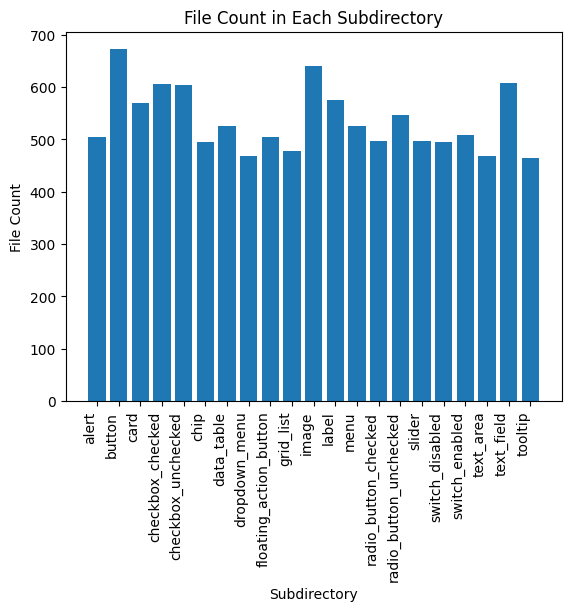

In [69]:
base_dir = "./data/ui_icons_dataset/"
train_dir = (os.path.join(base_dir,"train/"))

file_counts = []

for dir in os.listdir(train_dir):
    dir_path = os.path.join(train_dir,dir)
    file_counts.append(len(os.listdir(dir_path)))

plt.bar(os.listdir(train_dir), file_counts)
plt.xlabel('Subdirectory')
plt.ylabel('File Count')
plt.title('File Count in Each Subdirectory')
plt.xticks(rotation=90, ha='right') 
plt.show()

In [113]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.3,
      height_shift_range=0.3,
      shear_range=0.3,
      zoom_range=0.3,
      horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(224, 224),
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        class_mode='categorical')


Found 11249 images belonging to 21 classes.
Found 1241 images belonging to 21 classes.


In [108]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D, BatchNormalization

In [114]:
from tensorflow.keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D, concatenate
from tensorflow.keras.applications import MobileNet, VGG16
from tensorflow.keras.models import Model

input_combined = Input(shape=(224, 224, 3))

mobile_net_model = MobileNet(weights='imagenet', include_top=False, input_tensor=input_combined)
vgg16_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_combined)
mobile_net_output = mobile_net_model.output
vgg16_output = vgg16_model.output
merged_output = concatenate([mobile_net_output, vgg16_output])

x = GlobalAveragePooling2D()(merged_output)
x = Dropout(0.5)(x)

predictions = Dense(21, activation='softmax')(x)

ensemble_model = Model(inputs=input_combined, outputs=predictions)
ensemble_model.summary()

Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_48 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_48[0][0]']            
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)         128       ['conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['conv1_bn[0][0]']     

In [115]:
EPOCHS = 5
STEPS = 120
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5,min_delta=0.005, mode='max', verbose=1),
 ModelCheckpoint('Ensemble.h5', monitor='val_loss', mode='max', save_best_only=True, save_weights_only=True),
 EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

In [117]:
# Компіляція моделі
ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Навчання моделі
history = ensemble_model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/5
  1/120 [..............................] - ETA: 46:05 - loss: 4.0438 - accuracy: 0.0312

KeyboardInterrupt: 

In [ ]:
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()


plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

In [99]:
model_save_path = 'ensemble'

# Save the model
ensemble_model.save(model_save_path)

INFO:tensorflow:Assets written to: ensemble\assets


INFO:tensorflow:Assets written to: ensemble\assets


In [101]:
model_test  = tf.keras.models.load_model('ensemble')

base_dir = "./data/ui_icons_dataset/"
test_dir = os.path.join(base_dir, "test/test")

IDs2 = []
Target2 = []

for i in range(len(os.listdir(test_dir))):
    image = cv2.imread(os.path.join(test_dir,os.listdir(test_dir)[i]))
    image = cv2.resize(image,(224,224)) 
    image = image.reshape(1,224,224,3)

    IDs2.append(os.listdir(test_dir)[i])

    prediction = model_test.predict(image)
    max_index = np.argmax(prediction)

    Target2.append(os.listdir(train_dir)[max_index])

1/1 [==============================] - 0s 165ms/step


In [102]:
df2 = pd.DataFrame({'ID': IDs2, 'Target': Target2})

In [103]:
df2.to_csv('predictions_ensemble.csv', index=False)

In [104]:
df = pd.read_csv("predictions_ensemble.csv")

Target
radio_button_checked      1577
image                     1278
slider                     555
card                       507
checkbox_unchecked         501
text_field                 260
button                     106
switch_disabled             85
label                       59
data_table                  48
menu                        45
checkbox_checked            38
alert                       37
floating_action_button      25
tooltip                      8
grid_list                    8
chip                         4
radio_button_unchecked       2
Name: count, dtype: int64


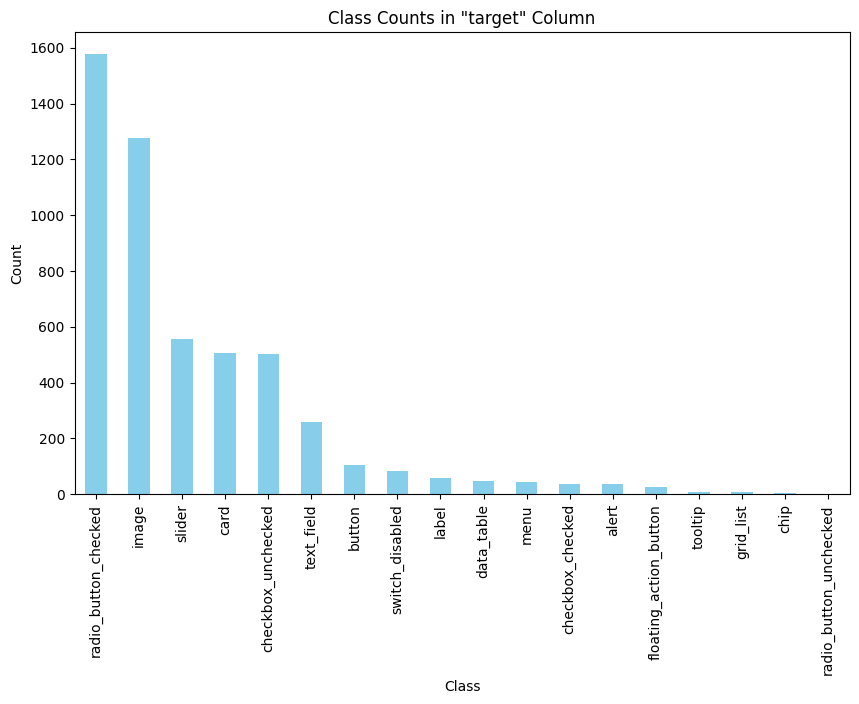

In [105]:
class_counts = df['Target'].value_counts()

# Display the class counts
print(class_counts)
class_counts.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Class Counts in "target" Column')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()